# Tabular Playground Series - Apr 2022

In this competition, you'll classify 60-second sequences of sensor data, indicating whether a subject was in either of two activity states for the duration of the sequence.

1. **train.csv** - the training set, comprising ~26,000 60-second recordings of thirteen biological sensors for almost one thousand experimental participants
* `sequence` - a unique id for each sequence
* `subject` - a unique id for the subject in the experiment
* `step` - time step of the recording, in one second intervals
* `sensor_00` - sensor_12 - the value for each of the thirteen sensors at that time step

2. **train_labels.csv** - the class label for each sequence.
* `sequence` - the unique id for each sequence.
* `state` - the state associated to each sequence. This is the `target` which you are trying to predict.

3. **test.csv** - the test set. For each of the ~12,000 sequences, you should predict a value for that sequence's state.
4. **sample_submission.csv** - a sample submission file in the correct format.

# Data overview

In [1]:
# Import all the tools
import warnings
from tqdm import tqdm_notebook
import seaborn as sns
from plotly.offline import init_notebook_mode
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import os  # access to folder
from os import path
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import tensorflow as tf
import time
import logging
import gc

from tensorflow.keras.layers import *
from tensorflow.keras import *
from tensorflow.keras.callbacks import *
from sklearn.model_selection import KFold
from tensorflow.keras.metrics import AUC
from sklearn.model_selection import train_test_split
# from sklearn.impute import IterativeImputer
warnings.filterwarnings("ignore")

cwd = os.getcwd()
cwd = cwd.replace('\\', '/')

train = pd.read_csv(cwd + "/tab_April/train.csv")
train_labels = pd.read_csv(cwd + "/tab_April/train_labels.csv")
test = pd.read_csv(cwd + "/tab_April/test.csv")
sub = pd.read_csv(cwd + "/tab_April/sample_submission.csv")

# plots inside the notebook
%matplotlib inline
print('Train Shape: {}\nMissing Data: {}\nDuplicates: {}\nMemory usage: {}\n'.format(
    train.shape, train.isna().sum().sum(), train.duplicated().sum(), np.around(train.memory_usage().sum() / 1024**2), 2))
print('Test Shape: {}\nMissing Data: {}\nDuplicates: {}\nMemory usage: {}\n'.format(
    test.shape, test.isna().sum().sum(), test.duplicated().sum(), np.around(test.memory_usage().sum() / 1024**2, 3)))

# remove duplicates from train
train_d = train.drop_duplicates()

if train.shape == train_d.shape:
    print('No duplicates')
else:
    print('Dropping Duplicates\nNew Train Shape: {}'.format(train_d.shape))

df_data = pd.concat([train_d, test])

Train Shape: (1558080, 16)
Missing Data: 0
Duplicates: 0
Memory usage: 190.0

Test Shape: (733080, 16)
Missing Data: 0
Duplicates: 0
Memory usage: 89.487

No duplicates


In [2]:
df_data.head(5)

,sequence,subject,step,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12
0,0,47,0,-0.196291,0.112395,1.0,0.329204,-1.004660,-0.131638,-0.127505,0.368702,-0.1,-0.963873,-0.985069,0.531893,4.751492
1,0,47,1,-0.447450,0.134454,1.0,-0.658407,0.162495,0.340314,-0.209472,-0.867176,0.2,-0.301301,0.082733,-0.231481,0.454390
2,0,47,2,0.326893,-0.694328,1.0,0.330088,0.473678,1.280479,-0.094718,0.535878,1.4,1.002168,0.449221,-0.586420,-4.736147
3,0,47,3,0.523184,0.751050,1.0,0.976991,-0.563287,-0.720269,0.793260,0.951145,-0.3,-0.995665,-0.434290,1.344650,0.429241
4,0,47,4,0.272025,1.074580,1.0,-0.136283,0.398579,0.044877,0.560109,-0.541985,-0.9,1.055636,0.812631,0.123457,-0.223359


In [3]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int8','int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2

    for col in df.columns:
        col_type = df[col].dtypes

        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()

            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2

    if verbose:
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
 
    return df

# EDA & FE

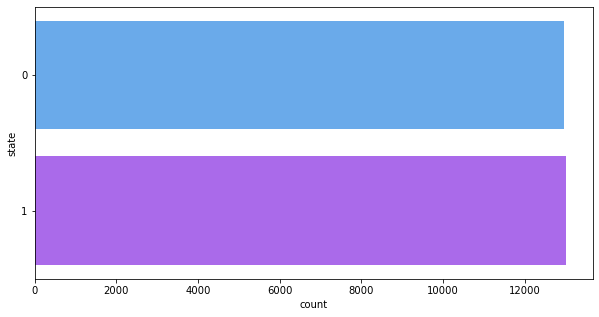

In [4]:
plt.figure(figsize=(10,5))
sns.countplot(y=train_labels['state'], palette='cool', orient='h')
plt.show()

In [5]:
df_data.dtypes

sequence       int64
subject        int64
step           int64
sensor_00    float64
sensor_01    float64
sensor_02    float64
sensor_03    float64
sensor_04    float64
sensor_05    float64
sensor_06    float64
sensor_07    float64
sensor_08    float64
sensor_09    float64
sensor_10    float64
sensor_11    float64
sensor_12    float64
dtype: object

In [6]:
df_data.sample(16, axis=1).describe().T.style.bar(
    subset=["mean"], color="#205ff2"
).background_gradient(subset=["std"], cmap="Reds").background_gradient(
    subset=["50%"], cmap="coolwarm"
)

,count,mean,std,min,25%,50%,75%,max
subject,2291160.000000,490.887158,287.621359,0.000000,238.000000,492.000000,742.000000,990.000000
sensor_01,2291160.000000,-0.001039,4.466203,-457.260504,-0.483193,0.003151,0.492647,551.537815
sensor_00,2291160.000000,0.000363,2.747429,-375.063369,-0.499227,-0.003091,0.483771,403.787481
sensor_06,2291160.000000,-0.000827,3.370294,-470.504554,-0.491803,0.000911,0.490893,484.381603
sensor_04,2291160.000000,-0.001293,1.749201,-24.754551,-0.488546,-0.000951,0.486831,24.872865
step,2291160.000000,29.500000,17.318106,0.000000,14.750000,29.500000,44.250000,59.000000
sensor_08,2291160.000000,-0.000019,4.663098,-544.900000,-0.500000,0.000000,0.500000,769.600000
sequence,2291160.000000,19092.500000,11023.351091,0.000000,9546.000000,19092.500000,28639.000000,38185.000000
sensor_11,2291160.000000,-0.003435,4.490679,-443.709877,-0.482510,0.003086,0.491770,448.020576
sensor_03,2291160.000000,-0.002250,4.261084,-425.277876,-0.491150,0.000885,0.487611,498.469027


In [7]:
train_labels[:5]

,sequence,state
0,0,0
1,1,1
2,2,1
3,3,1
4,4,1


Let's `merge` data with a `taget` value:

In [8]:
df_data = df_data.merge(train_labels, on='sequence', how='left')
df_data[:5]

,sequence,subject,step,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12,state
0,0,47,0,-0.196291,0.112395,1.0,0.329204,-1.004660,-0.131638,-0.127505,0.368702,-0.1,-0.963873,-0.985069,0.531893,4.751492,0.0
1,0,47,1,-0.447450,0.134454,1.0,-0.658407,0.162495,0.340314,-0.209472,-0.867176,0.2,-0.301301,0.082733,-0.231481,0.454390,0.0
2,0,47,2,0.326893,-0.694328,1.0,0.330088,0.473678,1.280479,-0.094718,0.535878,1.4,1.002168,0.449221,-0.586420,-4.736147,0.0
3,0,47,3,0.523184,0.751050,1.0,0.976991,-0.563287,-0.720269,0.793260,0.951145,-0.3,-0.995665,-0.434290,1.344650,0.429241,0.0
4,0,47,4,0.272025,1.074580,1.0,-0.136283,0.398579,0.044877,0.560109,-0.541985,-0.9,1.055636,0.812631,0.123457,-0.223359,0.0


In [9]:
# df_data.loc[(df_data['sequence'] == 1)]

## Baseline

In [10]:
def baseline(X, y):
    from sklearn.model_selection import cross_val_score
    from sklearn.ensemble import RandomForestClassifier
#     X = reduce_mem_usage(X)
    model = RandomForestClassifier()
    cv = cross_val_score(
        model, X, y, cv=2, scoring="accuracy", n_jobs=-1
    )
#     score = cv.mean()
    score = cv
    print(f"Baseline accuracy: {score}")
    return score

train_base = df_data[df_data.state.isnull() == False].copy() #limit rows to reduce time 
train_base.drop('sequence', axis=1, inplace=True) # remove id (sequence)
train_base = reduce_mem_usage(train_base) # memory reduction
X = train_base.drop('state', axis=1)
y = train_base['state']

# %time baseline(X,y)


# Baseline accuracy: [0.64863293 0.65158914]
# CPU times: total: 344 ms
# Wall time: 7min 12s

Mem. usage decreased to 99.56 Mb (50.7% reduction)


# Modeling

Let us use `Long short-term memory (LSTM)` as we are considering `memory-data`

In [11]:
from sklearn.preprocessing import RobustScaler

window  = 60

# remove unnecessary columns
df_data.drop(['sequence', 'subject', 'step'], axis=1, inplace=True)
df_train = df_data[df_data.state.isnull() == False]
df_test = df_data[df_data.state.isnull() == True]

# y
y = df_train['state'].to_numpy().reshape(-1, window)

# remove target
df_test.drop(['state'], axis=1, inplace=True)
df_train.drop('state', axis=1, inplace=True)

# standartization
rb = RobustScaler()
rb.fit(df_train)
df_train = rb.transform(df_train)
df_test = rb.transform(df_test)

# reshape to get new array
df_train = df_train.reshape(-1, window, df_train.shape[-1])
df_test = df_test.reshape(-1, window, df_test.shape[-1])

# X
X = df_train

In [12]:
def plotHist(hist):
    plt.plot(hist.history["auc"])
    plt.plot(hist.history["val_auc"])
    plt.title("model performance")
    plt.ylabel("area_under_curve")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

Tensorflow `Bi-LSTM:`

In [13]:
from tensorflow.distribute import Strategy
def createModel():   
    
    model = Sequential([

        Input(shape=(window , X.shape[-1])),
        Bidirectional(LSTM(700, return_sequences=True)),
        Bidirectional(LSTM(512, return_sequences=True)),
        Bidirectional(LSTM(256, return_sequences=True)),
        Bidirectional(LSTM(128, return_sequences=True)),
        Dense(128, activation='selu'),
        Dense(1, activation="sigmoid")
    ])

    model.compile(optimizer="adam",loss="binary_crossentropy", metrics=[AUC(name = 'auc')])
    return(model)

In [ ]:
from sklearn.model_selection import KFold
from keras.callbacks import EarlyStopping
kf = KFold(n_splits=10, shuffle=True, random_state=42)

test_preds = []

for fold, (train_idx, test_idx) in enumerate(kf.split(X, y)):
    print(f"****** fold: {fold+1} *******")
    X_train, X_valid = X[train_idx], X[test_idx]
    y_train, y_valid = y[train_idx], y[test_idx]
    
    es = EarlyStopping(monitor='val_accuracy',mode='max', patience=2, verbose=1, restore_best_weights=True)
    
    model = createModel()
        
    history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=50, batch_size = 256, callbacks = [es])
    test_preds.append(model.predict(df_test).squeeze())
    plotHist(history)
    del X_train, X_valid, y_train, y_valid, model, history
    gc.collect()  

In [ ]:
# model = createModel()

# history = model.fit(X, y, epochs=12, batch_size = 256)

In [ ]:
plotHist(history)

In [ ]:
# y_pred = model.predict(df_test).squeeze()

# Submission

In [ ]:
# l = []
# for i in range(0, len(y_pred)):
#     if sum(y_pred[i]/60) > 0.5:
#         l.append(1)
#     else:
#         l.append(0)

In [ ]:
sub["state"] = sum(test_preds)/kf.n_splits

# sub["state"] = l
sub.to_csv('E:/downloads/submission.csv', index=False)
sub   